<a href="https://colab.research.google.com/github/SaahitKar/Option-DeAmericanization/blob/main/AmericanOptionsAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from scipy.stats import norm

from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
from jax.scipy.stats import norm as jnorm
from functools import partial

# BBSR Implementation:

In [9]:
def payoff(S_0,N,j,u,d,K,is_call):
  S_t = S_0 * u**j * d**(N-j) # up j times, down N-j times
  if is_call:
    return np.maximum(S_t-K,0)
  else:
    return np.maximum(K-S_t,0)

def p_riskneutral(r,q,delta_time,u,d):
  return (math.exp((r-q)*delta_time)-d)/(u-d)

def black_scholes(params,is_call):
  S_0,K,T,sigma,r,q = params
  d1 = (np.log(S_0/K)+(r-q+sigma**2/2)*T)/(sigma*math.sqrt(T))
  d2 = d1 - sigma*math.sqrt(T)
  if is_call:
    return(S_0*math.exp(-q*T)*norm.cdf(d1) - K*math.exp(-r*T)*norm.cdf(d2))
  else:
    return(K*math.exp(-r*T)*norm.cdf(-d2) - S_0*math.exp(-q*T)*norm.cdf(-d1))

def backward_induce(V,S,u,pstar,disc,is_call,use_bs,bs_params,is_american):
  # perform one step of backward induction on state vectors V and S
  # Stock Update:
  S = S[:-1]*u

  # Determine Continuing Value
  if use_bs:
    K,delta,sigma,r,q = bs_params
    params = (S,K,delta,sigma,r,q)
    continuing_val = black_scholes(params,is_call)
  else:
    # otherwise use risk-neutral expectation of future prices
    K = bs_params
    continuing_val = (pstar * V[1:] + (1-pstar) * V[:-1]) * disc

  if is_american:
    # Excercise Value (when relevant)
    if is_call:
      exercise_val = np.maximum(S-K,0)
    else:
      exercise_val = np.maximum(K-S,0)
    V = np.maximum(continuing_val,exercise_val)
  else:
    V = continuing_val
  return V, S

def binomial_black_scholes(params,N,is_call,is_american):
  S_0,K,T,sigma,r,q = params
  delta = T/N # time step
  u = math.exp(sigma*math.sqrt(delta)) # CRR Assumptions
  d = 1/u

  pstar = p_riskneutral(r,q,delta,u,d) # risk neutral probability of up
  disc = math.exp(-r*delta) # discount per time step

  i = np.arange(N+1)
  S = S_0*u**(i)*d**(N-i) # initialize stock price range
  V = payoff(S_0,N,i,u,d,K,is_call) # initialize payoffs at maturity

  # start with Black Scholes prices (instead of payoffs)
  V,S = backward_induce(V,S,u,pstar,disc,is_call,True,(K,delta,sigma,r,q),is_american)

  for i in range(N-1):
    # and N - 1 rounds of typical backward induction
    V,S = backward_induce(V,S,u,pstar,disc,is_call,False,(K),is_american)
  return V[0]

def bbsr(params,N,is_call,is_american):
  if N%2 != 0:
    raise ValueError("N must be even")
  C1 = binomial_black_scholes(params,N//2,is_call,is_american)
  C2 = binomial_black_scholes(params,N,   is_call,is_american)
  return 2*C2 - C1

In [10]:
@jax.jit
def make_state_vectors(S_0,N,j,u,d,K,is_call):
    S = S_0 * u**j * d**(N-j) # up j times, down N-j times
    V = jnp.where(is_call, jnp.maximum(S-K,0), jnp.maximum(K-S,0))
    return V,S

@jax.jit
@partial(jax.vmap,in_axes=(0,None,None,None,None,None,None))
def fast_black_scholes(S_0,K,T,sigma,r,q,is_call):
    d1 = (jnp.log(S_0/K)+(r-q+sigma**2/2)*T)/(sigma*jnp.sqrt(T))
    d2 = d1 - sigma*jnp.sqrt(T)

    return jnp.where(is_call,
                     S_0*jnp.exp(-q*T)*jnorm.cdf(d1) - K*jnp.exp(-r*T)*jnorm.cdf(d2),
                     K*jnp.exp(-r*T)*jnorm.cdf(-d2) - S_0*jnp.exp(-q*T)*jnorm.cdf(-d1))


@partial(jax.jit,static_argnums=(1,3))
def fast_bbs(params,N,is_call,is_american):
    S_0,K,T,sigma,r,q = params
    delta = T/N
    u = jnp.exp(sigma*jnp.sqrt(delta))
    d = 1/u

    pstar = (jnp.exp((r-q)*delta)-d)/(u-d)
    disc = jnp.exp(-r*delta)

    i = jnp.arange(N+1)
    V,S = make_state_vectors(S_0,N,i,u,d,K,is_call)

    S = S[:-1]*u
    continuing_val = fast_black_scholes(S,K,delta,sigma,r,q,is_call)
    if is_american:
        exercise_val = jnp.where(is_call, jnp.maximum(S-K,0), jnp.maximum(K-S,0))
        V = jnp.maximum(continuing_val,exercise_val)
    else:
        V = continuing_val

    carry = (V,S)

    def step(_, carry):
        V,S = carry
        S = S[:-1]*u

        continuing_val = (pstar * V[1:] + (1-pstar) * V[:-1]) * disc
        if is_american:
            exercise_val = is_call*jnp.maximum(S-K,0) + (1-is_call)*jnp.maximum(K-S,0)
            V = jnp.maximum(continuing_val,exercise_val)
        else:
            V = continuing_val

        V_full = jnp.concatenate([V, jnp.zeros(1)], axis=0)
        S_full = jnp.concatenate([S, jnp.zeros(1)], axis=0)
        return (V_full,S_full)

    V_final,_ = jax.lax.fori_loop(0, N-1, step, carry)
    return V_final[0]

@partial(jax.jit,static_argnums=(1,3))
def fast_bbsr(params,N,is_call,is_american):
    if N%2 != 0:
        raise ValueError("N must be even")
    C1 = fast_bbs(params,N//2,is_call,is_american)
    C2 = fast_bbs(params,N,   is_call,is_american)
    return 2*C2 - C1

# Analysis of American Puts

## Sufficient Steps

In [16]:
def determine_sufficient_n(params,is_call,is_american):
    epsilon=1e-3
    big_N = 5000
    streak_limit = 10

    exact = bbsr(params,big_N,is_call,is_american)

    streak = 0
    n = 0
    while streak < streak_limit:
        n += 2
        est = bbsr(params,n,is_call,is_american)
        if abs(est-exact) <= epsilon:
            streak += 1
        else:
            streak = 0
    return n - (streak_limit - 1)*2

In [18]:
maturities = np.arange(1,13)/12
sufficient_ns_put = []

for t in maturities:
    n = determine_sufficient_n((100,100,t,0.20,0.05,0),is_call=False,is_american=True)
    sufficient_ns_put.append(n)
sufficient_ns_put = np.array(sufficient_ns_put)

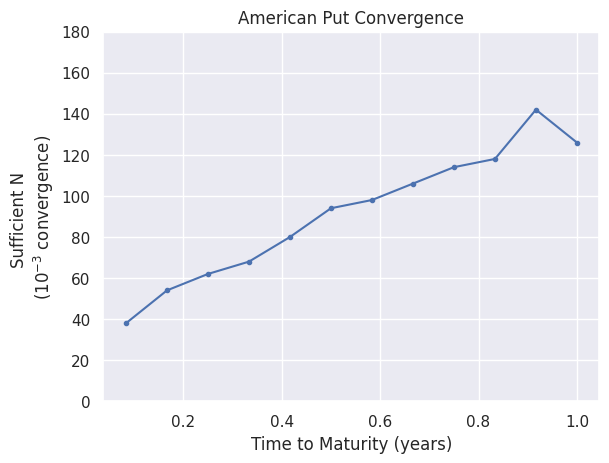

In [19]:
plt.plot(maturities,sufficient_ns_put,marker='.')

plt.title("American Put Convergence")
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Sufficient N \n($10^{-3}$ convergence)")
plt.ylim([0,180])

plt.show()

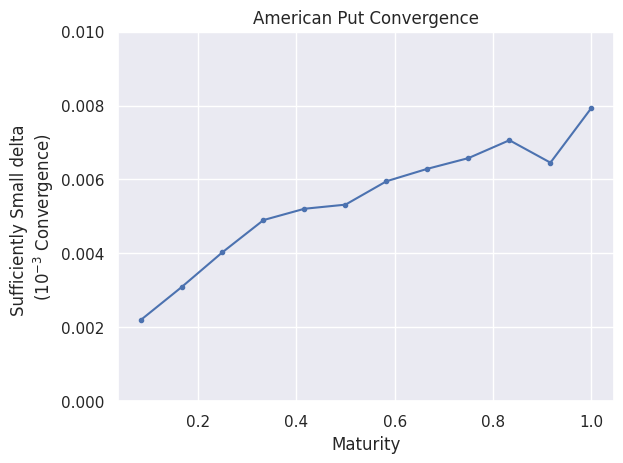

In [20]:
deltas_put = maturities/sufficient_ns_put

plt.plot(maturities,deltas_put,marker='.')

plt.title("American Put Convergence")
plt.xlabel("Maturity")
plt.ylabel("Sufficiently Small delta \n($10^{-3}$ Convergence)")
plt.ylim([0,0.01])

plt.show()

## Price vs $S_0$

In [21]:
S0_range = range(80,121)

no_dividend_range = [(S0,100,1,0.20,0.05,0) for S0 in S0_range]
with_dividend_range = [(S0,100,1,0.20,0.05,0.04) for S0 in S0_range]

tree_size = 200 # more than sufficient

no_dividend_put_prices = []
for params in no_dividend_range:
    price = fast_bbsr(params, tree_size, is_call=False, is_american=True)
    no_dividend_put_prices.append(price)

with_dividend_put_prices = []
for params in with_dividend_range:
    price = fast_bbsr(params, tree_size, is_call=False, is_american=True)
    with_dividend_put_prices.append(price)

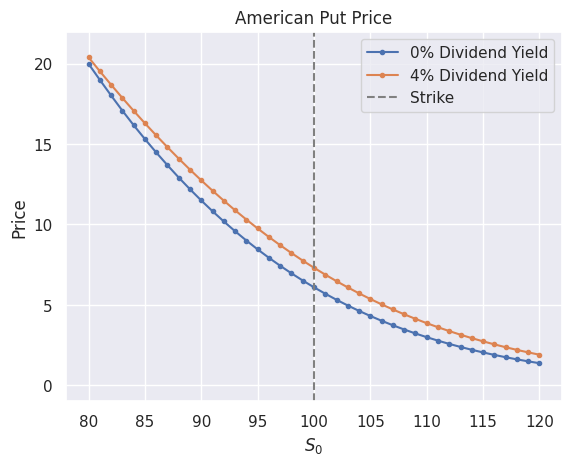

In [22]:
plt.plot(S0_range,no_dividend_put_prices,marker='.',label='0% Dividend Yield')
plt.plot(S0_range,with_dividend_put_prices,marker='.',label='4% Dividend Yield')
plt.axvline(100,color='gray',linestyle='--',label='Strike')

plt.title("American Put Price")
plt.xlabel("$S_0$")
plt.ylabel("Price")
plt.ylim([-1,22])

plt.legend()
plt.show()

Intuitively, the addition of a dividend makes the put option more valuable because dividends are subtracted from the price of the underlying, once paid. Downward pressure on the underlying price makes a put more attractive.

The upward shift is largest at the strike $K=100$, because deeply in-the-money options have nothing but intrinsic value, and deeply out-of-the money options are worthless regardless of $q$.

## Early Exercise Boundary

In [23]:
def find_exercise_boundary_binary(params,is_call):
    _, K, T, sigma, r, q = params
    tree_size = 200
    tolerance = 0.005 # tolerance to say that price = intrinsic value
    delta = 0.01 # minimum width of binary search, before quitting

    high_S = 2*K if is_call else K
    low_S = K if is_call else 0

    while high_S - low_S > delta:
        mid_S = (high_S + low_S)/2

        option_price = fast_bbsr((mid_S,K,T,sigma,r,q),tree_size,is_call,is_american=True)
        exercise_value = max(mid_S - K, 0) if is_call else max(K - mid_S, 0)

        exercise = abs(option_price - exercise_value) <= tolerance

        if is_call == exercise:
            # if call exercises or put doesn't exercise: lower S
            high_S = mid_S
        else:
            # if put exercises or call doesn't exercise: raise S
            low_S = mid_S
    return (high_S + low_S)/2

In [26]:
maturities = np.arange(13)/12
no_dividends = [(100,100,T,0.20,0.05,0) for T in maturities[1:]]
with_dividends = [(100,100,T,0.20,0.05,0.04) for T in maturities[1:]]

boundaries_put_nodiv = []
boundaries_put_withdiv = []

for params in no_dividends:
    boundaries_put_nodiv.append(find_exercise_boundary_binary(params,is_call=False))
for params in with_dividends:
    boundaries_put_withdiv.append(find_exercise_boundary_binary(params,is_call=False))

boundaries_put_nodiv.insert(0,100) # boundary at T=0 is strike K=100
boundaries_put_withdiv.insert(0,100)

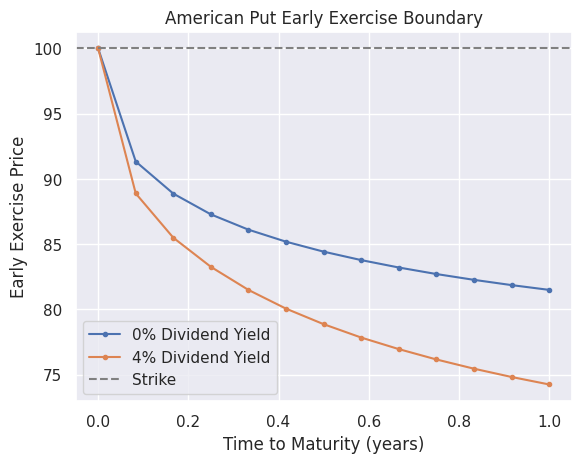

In [27]:
plt.plot(maturities,boundaries_put_nodiv,label='0% Dividend Yield',marker='.')
plt.plot(maturities,boundaries_put_withdiv,label='4% Dividend Yield',marker='.')
plt.axhline(100,color='gray',linestyle='--',label='Strike')

plt.xlabel("Time to Maturity (years)")
plt.ylabel("Early Exercise Price")
plt.title("American Put Early Exercise Boundary")

plt.legend()
plt.show()

The exercise boundary shifts downwards when the dividend is added. Intuitively, this is because selling the stock early means forgoing future dividend payments. If you hold the stock before selling, you directly receive (or forgo) those payments. Even if you don't hold the stock, you still benefit from (or miss out on) their downward pressure on the underlying price, explained above.

The size of the effect is larger when time to maturity is longer, since the foregone dividends have more time to accumulate.

## Analysis of American Calls

## Sufficient Steps

In [28]:
maturities = np.arange(1,13)/12
sufficient_ns_call = []

for t in maturities:
    n = determine_sufficient_n((100,100,t,0.20,0.05,0.04),is_call=True,is_american=True)
    sufficient_ns_call.append(n)
sufficient_ns_call = np.array(sufficient_ns_call)

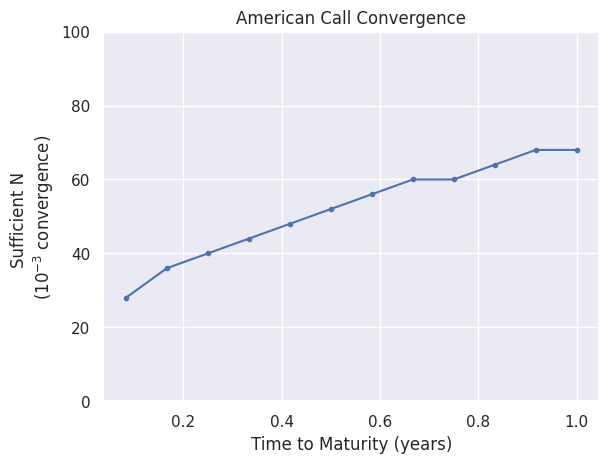

In [29]:
plt.plot(maturities,sufficient_ns_call,marker='.')

plt.title("American Call Convergence")
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Sufficient N \n($10^{-3}$ convergence)")
plt.ylim([0,100])

plt.show()

Note that these N's are lower than the equivalent N's for put options.

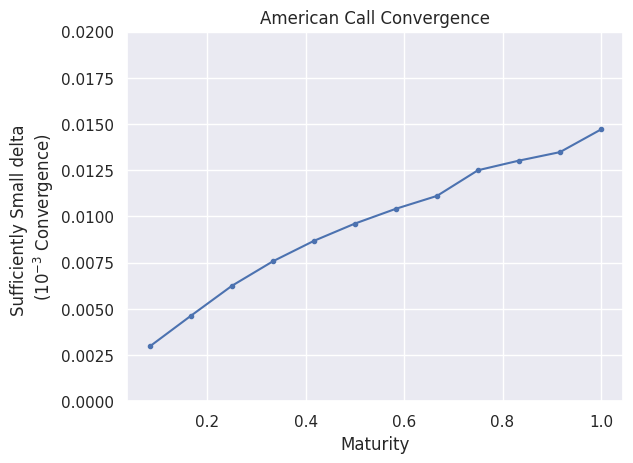

In [30]:
deltas_call = maturities/sufficient_ns_call

plt.plot(maturities,deltas_call,marker='.')

plt.title("American Call Convergence")
plt.xlabel("Maturity")
plt.ylabel("Sufficiently Small delta \n($10^{-3}$ Convergence)")
plt.ylim([0,0.02])

plt.show()

## Price vs $S_0$

In [31]:
low_dividend_range = [(S0,100,1,0.20,0.05,0.04) for S0 in S0_range]
high_dividend_range = [(S0,100,1,0.20,0.05,0.08) for S0 in S0_range]

tree_size = 100 # more than sufficient for calls

low_dividend_call_prices = []
for params in low_dividend_range:
    price = fast_bbsr(params, tree_size, is_call=True, is_american=True)
    low_dividend_call_prices.append(price)

high_dividend_call_prices = []
for params in high_dividend_range:
    price = fast_bbsr(params, tree_size, is_call=True, is_american=True)
    high_dividend_call_prices.append(price)

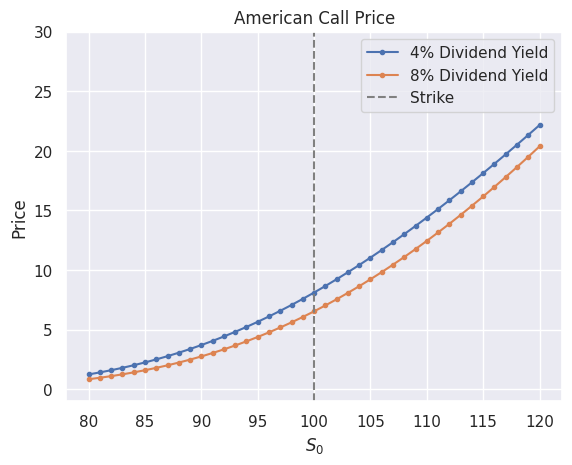

In [32]:
plt.plot(S0_range,low_dividend_call_prices,marker='.',label='4% Dividend Yield')
plt.plot(S0_range,high_dividend_call_prices,marker='.',label='8% Dividend Yield')
plt.axvline(100,color='gray',linestyle='--',label='Strike')

plt.title("American Call Price")
plt.xlabel("$S_0$")
plt.ylabel("Price")
plt.ylim([-1,30])

plt.legend()
plt.show()

The effect here is the opposite from with puts. Since an increased dividend yield puts a downward pressure on the price, calls become less attractive, not more.

The effect appears to be largest at or slightly above the money.

## Early Exercise Boundary

In [33]:
maturities = np.arange(13)/12
low_dividends = [(100,100,T,0.20,0.05,0.04) for T in maturities[1:]]
high_dividends = [(100,100,T,0.20,0.05,0.08) for T in maturities[1:]]

boundaries_lowdiv = []
boundaries_highdiv = []

for params in low_dividends:
    boundaries_lowdiv.append(find_exercise_boundary_binary(params,is_call=True))
for params in high_dividends:
    boundaries_highdiv.append(find_exercise_boundary_binary(params,is_call=True))

boundaries_lowdiv.insert(0,100) # boundary at T=0 is strike K=100
boundaries_highdiv.insert(0,100)

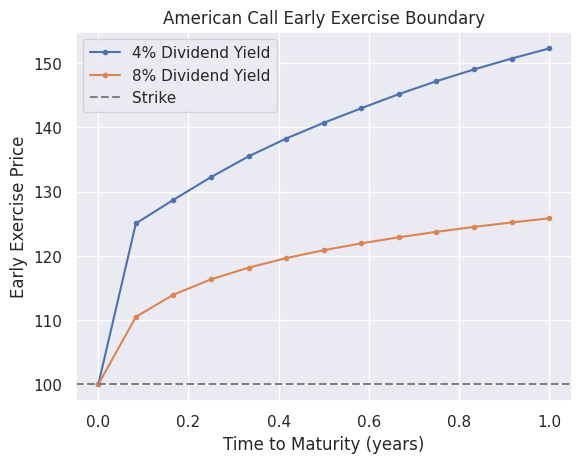

In [34]:
plt.plot(maturities,boundaries_lowdiv,label='4% Dividend Yield',marker='.')
plt.plot(maturities,boundaries_highdiv,label='8% Dividend Yield',marker='.')
plt.axhline(100,color='gray',linestyle='--',label='Strike')

plt.xlabel("Time to Maturity (years)")
plt.ylabel("Early Exercise Price")
plt.title("American Call Early Exercise Boundary")

plt.legend()
plt.show()

The effect here is in the same direction as with puts: The early exercise boundary shifts downwards. Intuitively, the higher dividend yield provides more incentive to exercise early and collect extra dividend. Equivalently, the increased downward pressure on the underlying price means the call is more likely to lose its value in the future, meaning you want to lock in its current value by exercising.

Again the size of the effect is larger for longer maturities, because the dividend has more time to accumulate.